# Finite Differences CapSol Example

Minimal example of using capsol python code to compute the voltage between a SPM tip (sphere, cone, and cantilever body disk) and a metal surface.

In [36]:
 %load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [37]:
%matplotlib inline

In [38]:

import numpy as np
from scipy import linalg
from scipy import sparse
from scipy.sparse import linalg as la
import capsol
import matplotlib.pyplot as plt


In [43]:
params= capsol.Params(Nr=950, Nz_plus=950, rhoMax=20*40000.0, zMax=20*40000.0, d=200.0)

In [44]:
sim = capsol.CapSol(params)

In [45]:
%time sim.setup_matrices()

CPU times: user 31.9 s, sys: 537 ms, total: 32.4 s
Wall time: 32.6 s


In [46]:
%time sim.solve()

CPU times: user 9min 18s, sys: 28.1 s, total: 9min 46s
Wall time: 58 s


In [47]:
%time sim.process()

CPU times: user 82.8 ms, sys: 32.1 ms, total: 115 ms
Wall time: 114 ms


1.67862637267536e-15

In [50]:
sim.energy_z

9.913820198394922e-16

In [51]:
sim.r_ratio

1.0111900000000733

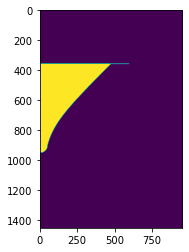

In [52]:
plt.imshow(sim.spm_tip[::-1, :])



(-200.0, 1000.0)

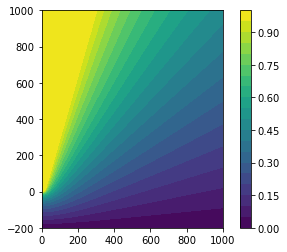

In [57]:
fig, ax = plt.subplots()
s = np.s_[:, :]
plt.contourf(sim.R[s], sim.Z[s], sim.u.reshape((sim.Nz, sim.Nr))[s], levels=20)
plt.colorbar()
ax.set_aspect('equal')
plt.xlim(0, 1000)
plt.ylim(-200, 1000)

In [60]:
params2 = capsol.Params(Nr=950, Nz_plus=950, rhoMax=20*40000.0, zMax=20*40000.0, d=200.0+0.4*2)
sim2 = capsol.CapSol(params2)
sim2.setup_matrices()
sim2.solve()
sim2.process()

1.6785653446964872e-15

In [64]:
params3 = capsol.Params(Nr=950, Nz_plus=950, rhoMax=20*40000.0, zMax=20*40000.0, d=200.0-0.4*2)
sim3 = capsol.CapSol(params3)
sim3.setup_matrices()
sim3.solve()
sim3.process()

1.6786874543611163e-15

In [73]:
C = sim.energy # 1 V applied, so E(J) = C(F)

In [72]:
C_z = (sim3.energy - sim2.energy ) / ((sim3.params.d - sim2.params.d)*1e-9)

In [71]:
C_zz = (sim3.energy + sim2.energy - 2*sim.energy ) / (((sim3.params.d - sim2.params.d)**2)*1e-18)

In [74]:
2*C_z**2 / (C_zz * C)

0.3307852070845099

In [66]:
(sim3.energy_z, sim.energy_z, sim2.energy_z)

(9.914234186716788e-16, 9.913820198394922e-16, 9.91340648842072e-16)

In [22]:
energy_z = 0.5 * np.sum(dV * capsol.E_field(u, sim.r, sim.z).imag**2) * 1e-9 * 8.854e-12

In [23]:
energy_z

9.986787027377295e-16

In [24]:
# All the energy related to the radial field is not helpful / useful...

In [25]:
E_J = energy * 1e-9 * 8.854e-12
E_J

1.4968089451750901e-35

In [26]:
sim

CapSol(params=Params(Rtip=20.0, theta_deg=15.0, Hcone=15000.0, Hcant=500.0, Rcant=15000.0, zMax=400000.0, rhoMax=400000.0, h0=0.4, d=200.0, Nuni=50, Nr=900, Nz_plus=900, hsam=0.0, theta=0.2617993877991494))

In [27]:
# E-field is V/m, here V/nm...
# dV = nm^3
# Units are V^2 * nm...

In [33]:
class arrayBuilder:
    def __init__(self, estimated_size=None):
        self.rows = []
        self.cols = []
        self.data = []
    
    def __call__(self, row, col, data):
        self.rows.append(row)
        self.cols.append(col)
        self.data.append(data)

In [34]:
def poisson_variable_spacing_radial(x, y):
    Nx = len(x)
    Ny = len(y)
    hx = np.diff(x)
    hy = np.diff(y)
    rows = []
    cols = []
    data = []
    ab = arrayBuilder()
    for i in range(Ny):
        for j in range(Nx): # Radial
            ind = i * Nx + j # This point
            ixp = ind + 1    # +x 
            ixn = ind - 1    # -x
            iyp = (i+1)*Nx + j  # +y
            iyn = (i-1)*Nx + j  # -y
            
            
            Dx_plus = hx[j] if j < (Nx-1) else 0.0
            Dx_minus = hx[j-1] if j > 0 else hx[j]
            x0 = x[j]
            Dy_plus = hy[i] if i < (Ny-1) else 0.0
            Dy_minus = hy[i-1] if i > 0 else 0.0
            
            prefactor_x = 4/((Dx_plus+Dx_minus)*(Dx_plus**2 + Dx_minus**2))
            
            prefactor_y = 4/((Dy_plus+Dy_minus)*(Dy_plus**2 + Dy_minus**2))

            

            diag_ind = (Dx_plus+Dx_minus) * prefactor_x + (Dy_plus+Dy_minus) * prefactor_y
            if j == 0:
                ab(ind, ixp, -2 * Dx_minus * prefactor_x) # That's it, no radial derivative here...
            elif j < (Nx - 1):
                ab(ind, ixp, -1 * Dx_minus * prefactor_x + -1 / (x0 * (Dx_plus+Dx_minus)))
            
                
            
            if j > 0:
                ab(ind, ixn, -1 * Dx_plus * prefactor_x + 1 / (x0 * (Dx_plus+Dx_minus)))
            
            if j == (Nx - 1):
                diag_ind += -1 / (x0 * (Dx_plus+Dx_minus)) # 1st order difference uses the grid point here...
            
            ab(ind, ind, diag_ind)
            
            if i > 0:
                ab(ind, iyn,  -1 * Dy_plus * prefactor_y)
            if i < (Ny-1):
                ab(ind, iyp, -1 * Dy_minus * prefactor_y)
    
    return sparse.csr_matrix(sparse.coo_matrix((ab.data, (ab.rows, ab.cols)), shape=(Nx*Ny, Nx*Ny))) # Convert to better

In [41]:
%time capsol.poisson_variable_spacing_radial(sim.r, sim.z)

CPU times: user 30.1 s, sys: 612 ms, total: 30.7 s
Wall time: 31.1 s


<1262301x1262301 sparse matrix of type '<class 'numpy.float64'>'
	with 6305099 stored elements in Compressed Sparse Row format>

In [42]:
%time capsol.poisson_variable_spacing_radial_faster(sim.r, sim.z)

CPU times: user 13.2 s, sys: 400 ms, total: 13.6 s
Wall time: 13.7 s


<1262301x1262301 sparse matrix of type '<class 'numpy.float64'>'
	with 6306901 stored elements in Compressed Sparse Row format>

In [ ]:
sim.

In [ ]:
sparse.coo_matrix()